In [12]:

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from textblob import TextBlob


In [13]:
# Function to collect historical stock data
def get_stock_data(tickers, start_date, end_date):
    """
    Fetch historical stock data for multiple tickers from Yahoo Finance.

    Args:
        tickers (list): List of stock ticker symbols (e.g., ['AAPL', 'MSFT']).
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Stock price data for all tickers.
    """
    stock_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    all_data = []
    for ticker in tickers:
        if ticker in stock_data.columns.levels[0]:
            df = stock_data[ticker].copy()
            df.reset_index(inplace=True)
            df['Ticker'] = ticker
            df['Date'] = pd.to_datetime(df['Date']).dt.date  # Convert to date format
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


In [14]:
# Fetch news headlines from uploaded datasets
def fetch_news_from_csv():
    """
    Fetch news headlines from provided CSV files.

    Returns:
        pd.DataFrame: Combined news data from all sources with Time, Headline, and Description.
    """
    # Load datasets
    reuters = pd.read_csv('/home/samyak/PycharmProjects/Master_Thesis_Enhancing_Stock_Price_Prediction_FinBERT/News_Dataset/reuters_headlines.csv')
    guardian = pd.read_csv('/home/samyak/PycharmProjects/Master_Thesis_Enhancing_Stock_Price_Prediction_FinBERT/News_Dataset/guardian_headlines.csv')
    cnbc = pd.read_csv('/home/samyak/PycharmProjects/Master_Thesis_Enhancing_Stock_Price_Prediction_FinBERT/News_Dataset/cnbc_headlines.csv')

    # Standardize 'Time' column and handle missing values
    for dataset, name in zip([cnbc, guardian, reuters], ['CNBC', 'Guardian', 'Reuters']):
        if 'Time' in dataset.columns:
            dataset['Time'] = dataset['Time'].str.replace(r"ET.*", "", regex=True).str.strip()
        else:
            dataset['Time'] = None

    # Combine datasets
    combined_news_data = pd.concat(
        [
            cnbc[['Time', 'Headlines', 'Description']].assign(Source='CNBC'),
            guardian[['Time', 'Headlines']].assign(Description=None, Source='Guardian'),
            reuters[['Time', 'Headlines', 'Description']].assign(Source='Reuters')
        ],
        ignore_index=True
    )

    # Drop rows with missing 'Headlines'
    combined_news_data.dropna(subset=['Headlines'], inplace=True)
    combined_news_data.reset_index(drop=True, inplace=True)
    return combined_news_data


In [15]:
# Analysis and visualization functions
def analyze_and_visualize_stock(stock_data):
    """
    Perform analysis and visualization for stock data.
    """
    print("\nStock Data Overview:")
    print(stock_data.describe())

    # Plot Closing Prices for Each Ticker
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    for ticker in stock_data['Ticker'].unique():
        ticker_data = stock_data[stock_data['Ticker'] == ticker]
        plt.figure(figsize=(10, 6))
        plt.plot(ticker_data['Date'], ticker_data['Close'], label=f"{ticker} Closing Price")
        plt.title(f"{ticker} Closing Prices Over Time")
        plt.xlabel("Date")
        plt.ylabel("Closing Price")
        plt.legend()
        plt.grid()
        plt.show()

In [16]:
def analyze_and_visualize_news(news_data):
    """
    Perform analysis and visualization for news data.
    """
    # Sentiment Analysis
    print("\nPerforming sentiment analysis on news headlines...")
    news_data['Sentiment'] = news_data['Headlines'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Average Sentiment by Source
    sentiment_by_source = news_data.groupby('Source')['Sentiment'].mean()
    print("\nAverage Sentiment by Source:")
    print(sentiment_by_source)

    # Visualize Sentiment by Source
    plt.figure(figsize=(10, 6))
    sentiment_by_source.plot(kind='bar', color=['blue', 'green', 'orange'])
    plt.title("Average Sentiment Polarity by Source")
    plt.xlabel("Source")
    plt.ylabel("Average Sentiment Polarity")
    plt.grid()
    plt.show()

    

Starting main workflow...


[*********************100%***********************]  5 of 5 completed


Stock data fetched successfully. Shape: (2405, 7)
News data fetched successfully. Shape: (53370, 4)

Stock Data Overview:
Price         Open         High          Low        Close        Volume
count  2405.000000  2405.000000  2405.000000  2405.000000  2.405000e+03
mean    210.536897   213.052127   208.076761   210.684188  5.610994e+07
std      90.263546    90.876551    89.431578    90.170097  4.104185e+07
min      83.029999    85.419998    81.430000    83.120003  9.932800e+06
25%     149.072355   151.092266   147.880005   149.527954  2.669820e+07
50%     182.860001   184.990005   180.690002   182.981308  4.380800e+07
75%     243.240005   247.550003   238.880005   243.386780  6.889080e+07
max     466.159796   467.507368   463.624357   466.718781  3.186799e+08


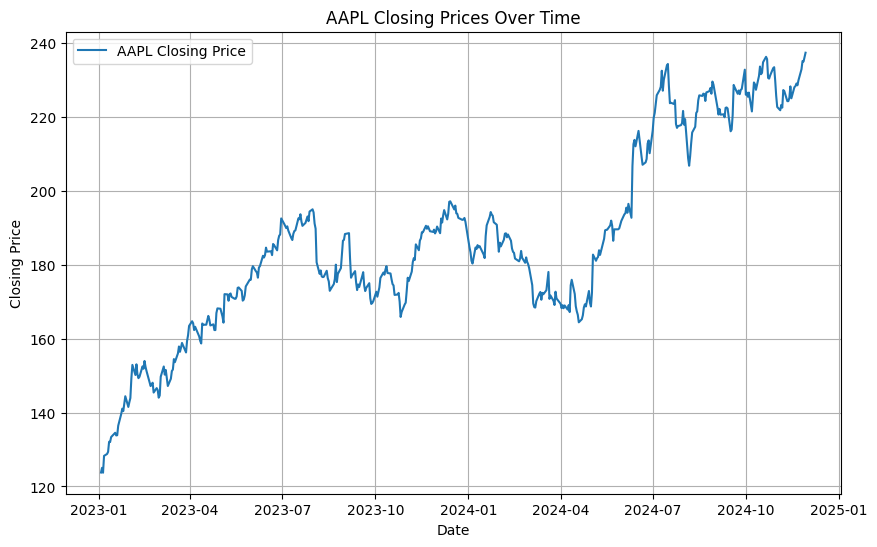

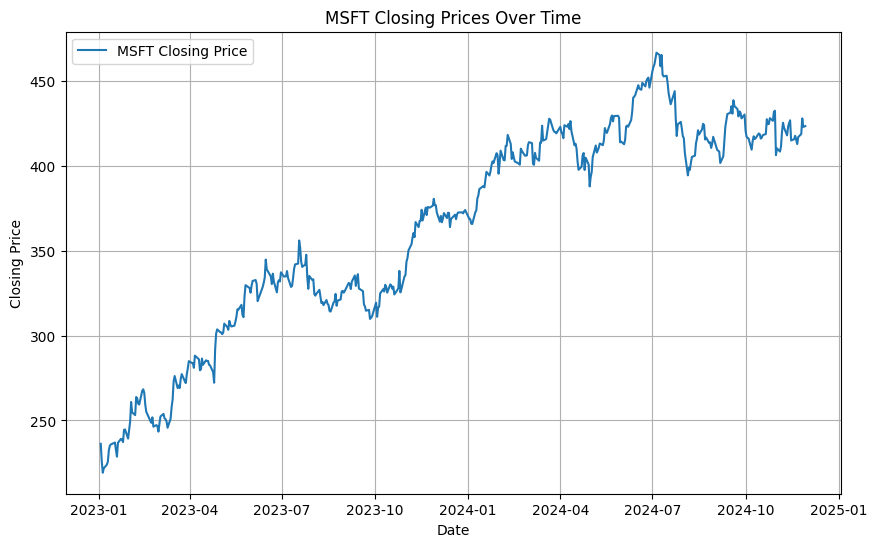

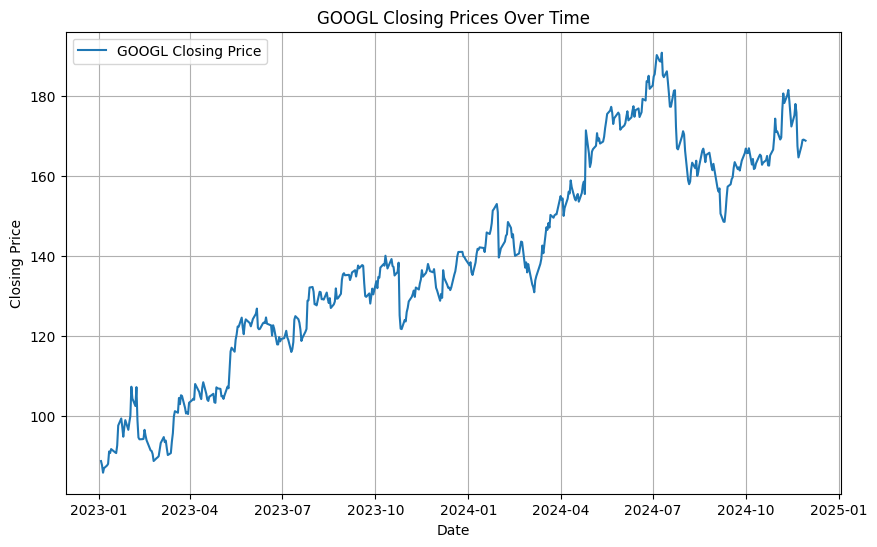

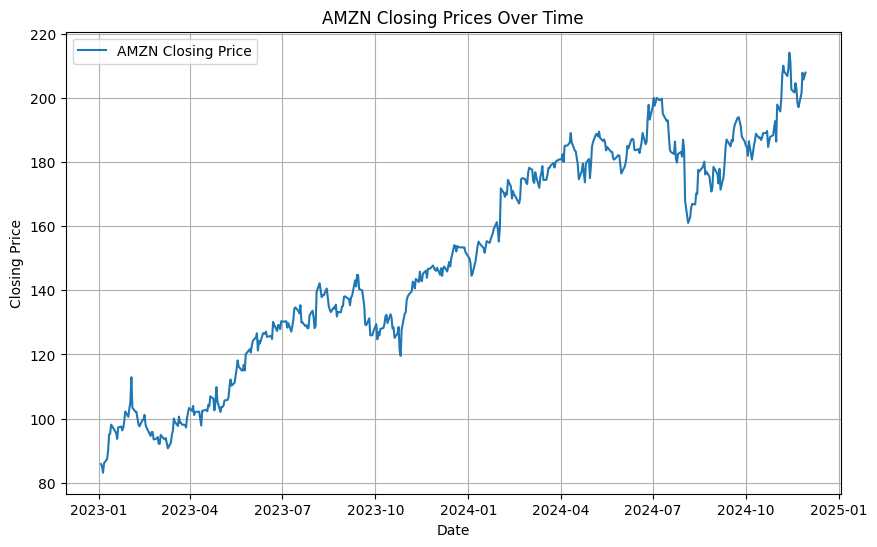

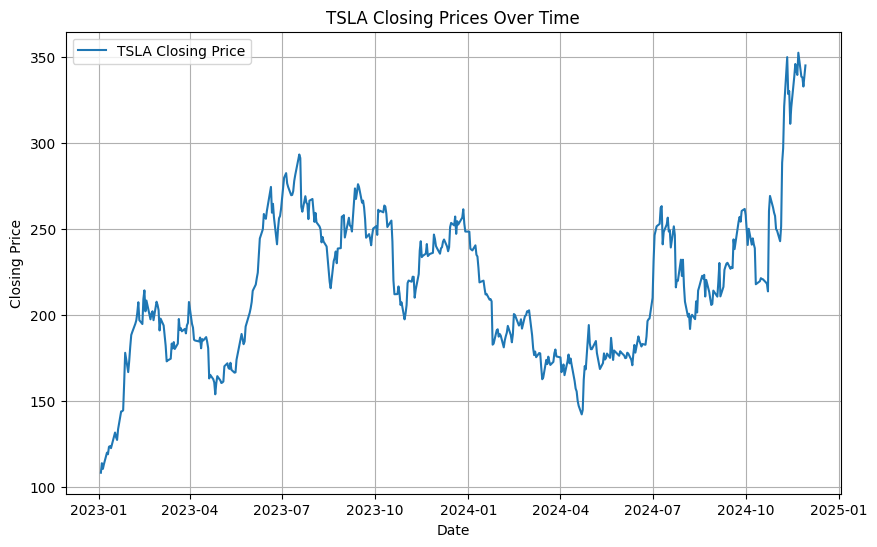


Performing sentiment analysis on news headlines...

Average Sentiment by Source:
Source
CNBC        0.020439
Guardian    0.018727
Reuters     0.027163
Name: Sentiment, dtype: float64


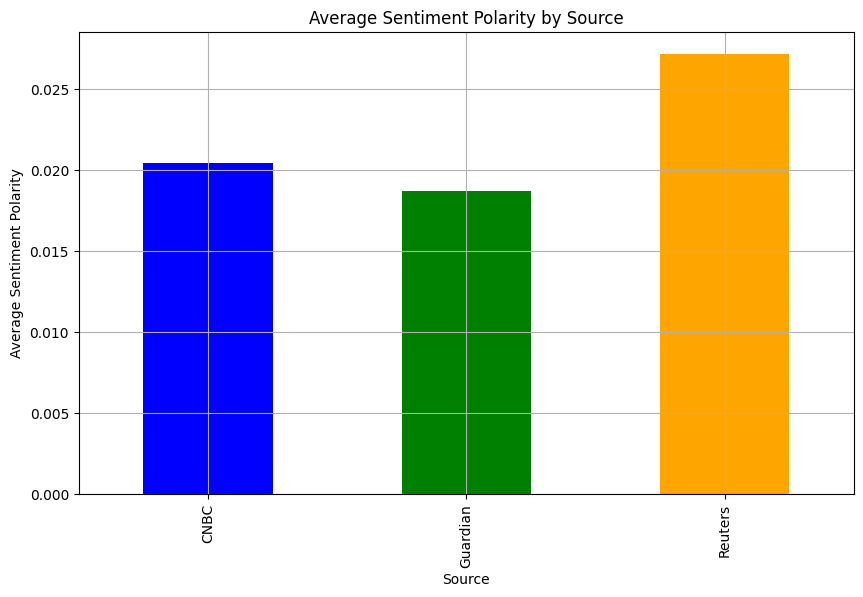

Saving news data to 'news_data_combined.csv'...
News data saved successfully.
Main workflow completed.


In [17]:
# Main workflow
if __name__ == "__main__":
    print("Starting main workflow...")
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']  # Add more tickers as needed
    start_date = '2023-01-01'  # Start date for fetching data
    end_date = '2024-12-01'  # End date for fetching data

    # Fetch stock data for multiple tickers
    try:
        stock_data = get_stock_data(tickers, start_date=start_date, end_date=end_date)
        print(f"Stock data fetched successfully. Shape: {stock_data.shape}")
    except Exception as e:
        print(f"Error fetching stock data: {e}")

    # Fetch news data from uploaded datasets
    try:
        news_data = fetch_news_from_csv()
        print(f"News data fetched successfully. Shape: {news_data.shape}")
    except ValueError as e:
        print(f"Error fetching news data: {e}")
        news_data = pd.DataFrame()

    # Perform analysis and visualization
    if not stock_data.empty:
        analyze_and_visualize_stock(stock_data)

    if not news_data.empty:
        analyze_and_visualize_news(news_data)

    # Save or display the result
    if not news_data.empty:
        print("Saving news data to 'news_data_combined.csv'...")
        news_data.to_csv("news_data_combined.csv", index=False)
        print("News data saved successfully.")
    else:
        print("No valid news data available.")

    print("Main workflow completed.")

In [18]:
import pandas as pd
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk
from datetime import datetime

In [19]:
# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /home/samyak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/samyak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/samyak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# Initialize FinBERT pipeline
finbert = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

2024-12-25 12:35:39.151696: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Device set to use 0


In [21]:
# Preprocessing function for headlines
def preprocess_headline(headline):
    """
    Preprocess the text by:
    - Converting to lowercase.
    - Removing stopwords, punctuation, and irrelevant symbols.
    - Tokenizing the text into words.
    - Applying lemmatization.

    Args:
        headline (str): The news headline to preprocess.

    Returns:
        str: The cleaned and preprocessed headline.
    """
    if pd.isna(headline):
        return ""

    # Convert to lowercase
    headline = headline.lower()

    # Remove punctuation and tokenize
    tokens = word_tokenize(headline.translate(str.maketrans('', '', string.punctuation)))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return ' '.join(lemmatized_tokens)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
# Baseline clustering model
def baseline_clustering(news_data):
    """
    Perform baseline clustering using K-Means on the news headlines.

    Args:
        news_data (pd.DataFrame): The news dataset containing a 'Headlines' column.

    Returns:
        pd.DataFrame: The dataset with an added 'Cluster' column.
    """
    print("Preprocessing headlines for clustering...")
    news_data['Processed_Headlines'] = news_data['Headlines'].apply(preprocess_headline)

    print("Vectorizing headlines...")
    vectorizer = CountVectorizer(max_features=1000)
    X = vectorizer.fit_transform(news_data['Processed_Headlines'])

    print("Applying K-Means clustering...")
    kmeans = KMeans(n_clusters=3, random_state=42)
    news_data['Cluster'] = kmeans.fit_predict(X)

    print("Calculating silhouette score...")
    score = silhouette_score(X, kmeans.labels_)
    print(f"Silhouette Score for baseline clustering: {score}")

    return news_data, score


In [31]:
# Example usage
if __name__ == "__main__":
    print("Loading financial news data...")
    print("Running baseline clustering...")
    news_data_with_clusters, baseline_score = baseline_clustering(news_data)
    print(f"Baseline clustering completed with silhouette score: {baseline_score}")


Loading financial news data...
Running baseline clustering...
Preprocessing headlines for clustering...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/home/samyak/nltk_data'
    - '/home/samyak/PycharmProjects/Master_Thesis_Enhancing_Stock_Price_Prediction_FinBERT/.venv/nltk_data'
    - '/home/samyak/PycharmProjects/Master_Thesis_Enhancing_Stock_Price_Prediction_FinBERT/.venv/share/nltk_data'
    - '/home/samyak/PycharmProjects/Master_Thesis_Enhancing_Stock_Price_Prediction_FinBERT/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
